In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv()
print(load_dotenv(dotenv_path=dotenv_path))

True


In [3]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import scipy.stats as stats
from src.crypto.import_utils import (
    import_crypto_prices_cryptocompare, 
    import_crypto_prices_coingecko,
    import_crypto_prices_binance
)

from src.crypto.utils import (compute_log_returns, 
                              compute_percentage_changes,
                              adf_test,
                              kpss_test
)

In [37]:
first_fetch = False

In [38]:
if first_fetch:
    df = import_crypto_prices_binance(limit = 5, current = False)
    df.to_csv("../data/binance/hbar.csv", index=False)
else:
    df_past = pd.read_csv("../data/binance/hbar.csv") 
    last_timestamp = pd.to_datetime(df_past.iloc[-1].time_stamp)
    current_time = pd.Timestamp.now()
    hours_diff = int((current_time - last_timestamp) // pd.Timedelta(hours=1))
    print(f"Hours difference: {hours_diff}")
    if hours_diff > 1:
        df_current = import_crypto_prices_binance(limit = hours_diff)
        df = pd.concat([df_past, df_current], ignore_index=True, axis = 0)
        df.to_csv("../data/binance/hbar.csv", index=False)
    else:
        df = df_past

Hours difference: 1


In [43]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   time_stamp          17520 non-null  datetime64[ns]
 1   open                17520 non-null  float64       
 2   high                17520 non-null  float64       
 3   low                 17520 non-null  float64       
 4   close               17520 non-null  float64       
 5   volume              17520 non-null  float64       
 6   close_time          17520 non-null  int64         
 7   quote_volume        17520 non-null  float64       
 8   trades              17520 non-null  int64         
 9   taker_base_volume   17520 non-null  float64       
 10  taker_quote_volume  17520 non-null  float64       
 11  ignore              17520 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 1.6 MB


### Hourly Prices

In [66]:
df_hourly = df.copy()

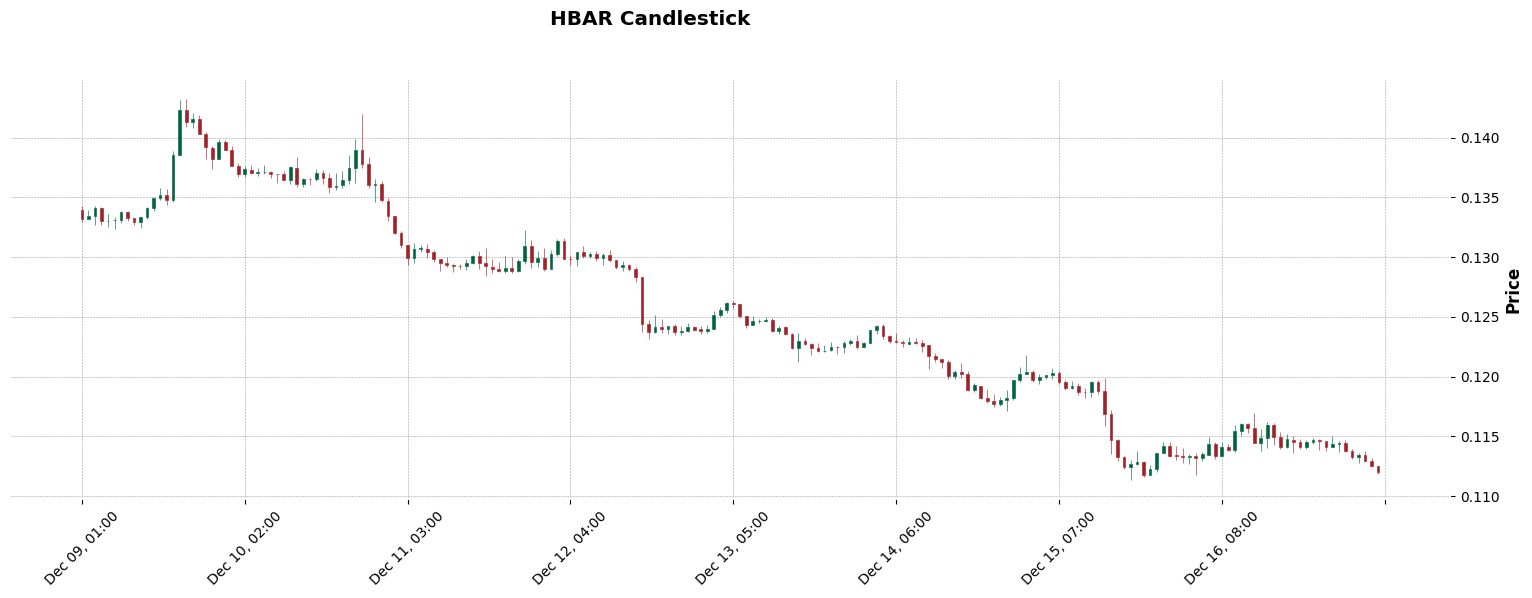

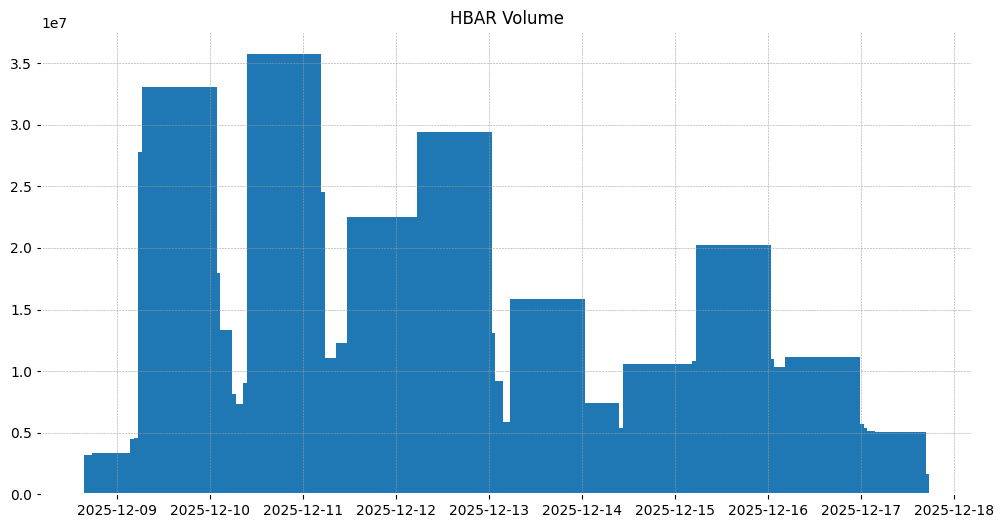

In [67]:
df_plot = df_hourly[-200:].copy()
df_plot = df_plot.set_index("time_stamp")

# ---- Candlestick chart ----
mpf.plot(
    df_plot,
    type="candle",
    style="charles",
    volume=False,
    title="HBAR Candlestick",
    figsize = (20,6)
)

# ---- Volume chart (separate) ----
plt.figure(figsize=(12,6))
plt.bar(df_plot.index, df_plot["volume"], width=0.8)
plt.title("HBAR Volume")
plt.show()

In [68]:
df_hourly['pct_change']  = compute_percentage_changes(df_hourly['close'])
df_hourly['log_return']= compute_log_returns(df_hourly['close'])
df_hourly = df_hourly.dropna()

In [69]:
df_hourly['pct_change'].mul(100).describe()

count    17518.000000
mean         0.009416
std          1.186808
min        -17.354438
25%         -0.519745
50%          0.000000
75%          0.503517
max         22.520355
Name: pct_change, dtype: float64

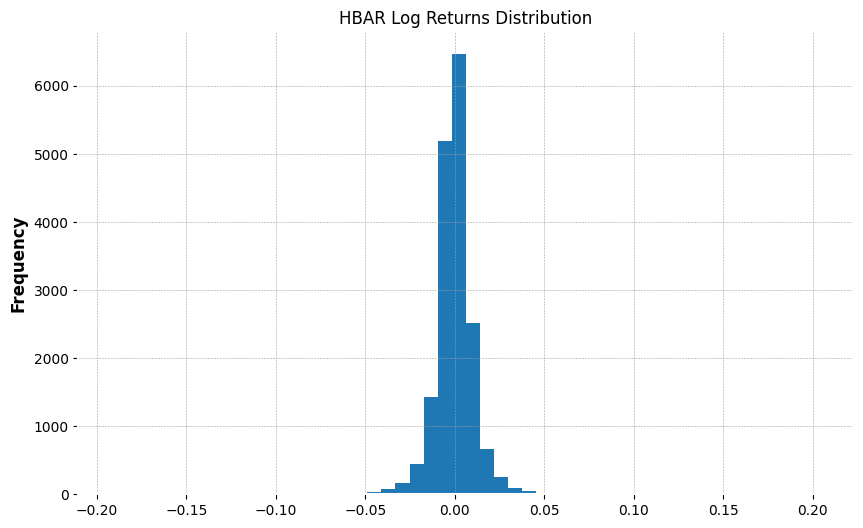

In [70]:
df_hourly.log_return.plot(kind='hist', bins=50, figsize=(10,6), title="HBAR Log Returns Distribution")
plt.show()

In [80]:
# Find all candles where the open price is greater than the previous close price
df_hourly[(df_hourly.open - df_hourly.close.shift()) > 0.001]

,time_stamp,open,high,low,close,volume,close_time,quote_volume,trades,taker_base_volume,taker_quote_volume,ignore,pct_change,log_return


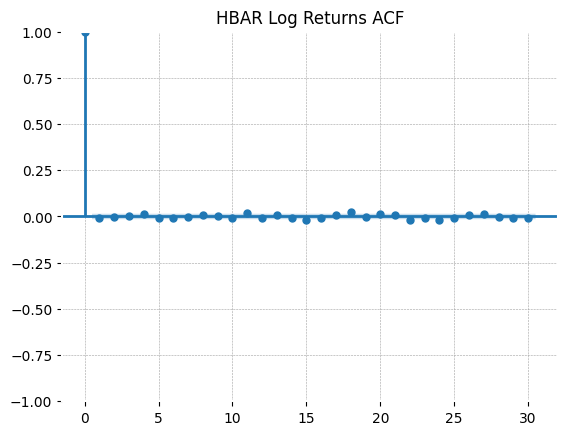

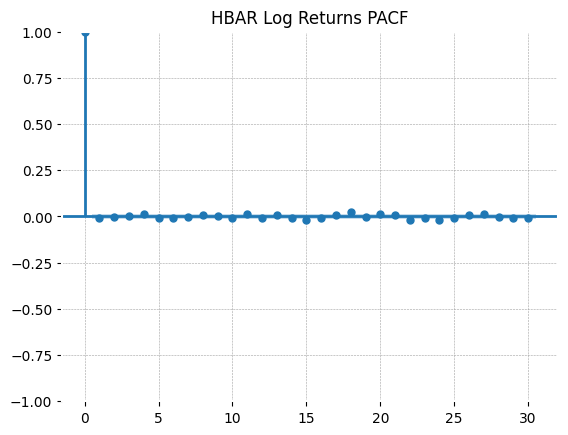

In [72]:
plot_acf(df_hourly['log_return'], lags=30, title="HBAR Log Returns ACF");
plot_pacf(df_hourly['log_return'], lags=30, title="HBAR Log Returns PACF");

In [73]:
# Perform ADF test: time series stationarity test
adf_test(df_hourly['log_return'])
print("\n")
# Perform KPSS test: time series stationarity test
kpss_test(df_hourly['log_return'])

Results of Dickey-Fuller Test:
Test Statistic                   -19.077721
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    17473.000000
Critical Value (1%)               -3.430724
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


Results of KPSS Test:
Test Statistic           0.153792
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


D:\My Files\Projects\Python\trade-tools\src\crypto\utils.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


### Daily Prices

In [81]:
df_daily = df_hourly.resample('D', on='time_stamp').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).reset_index()

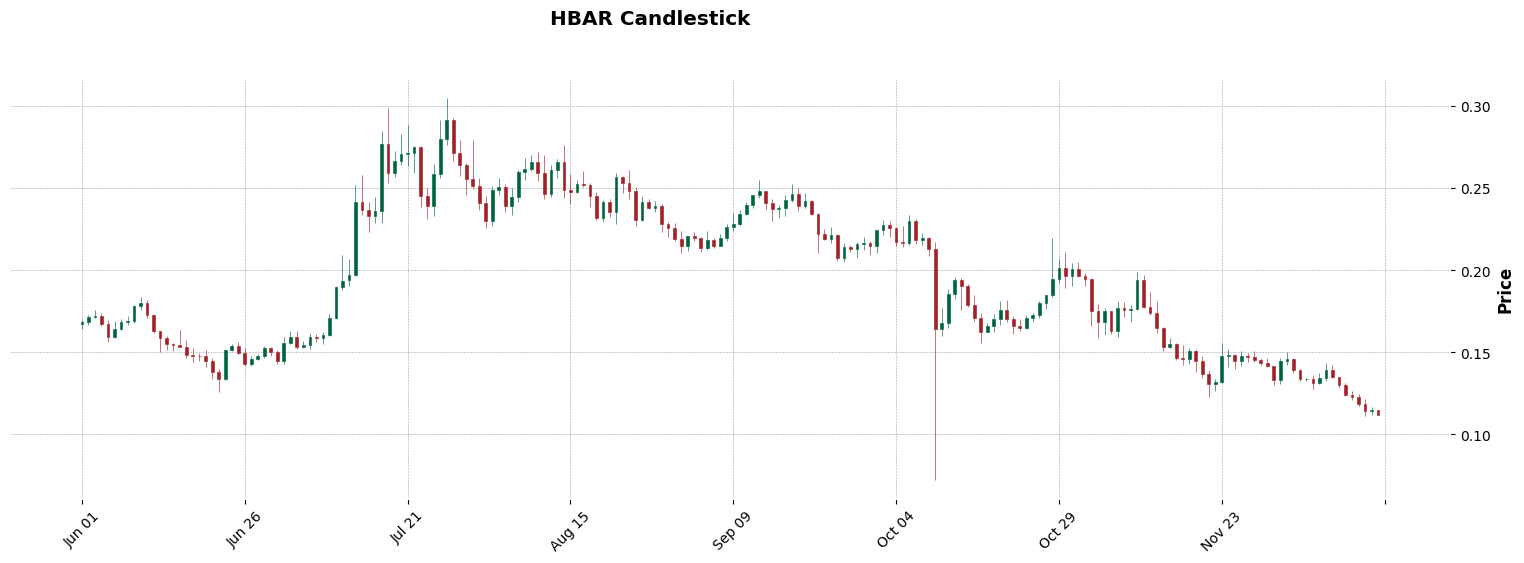

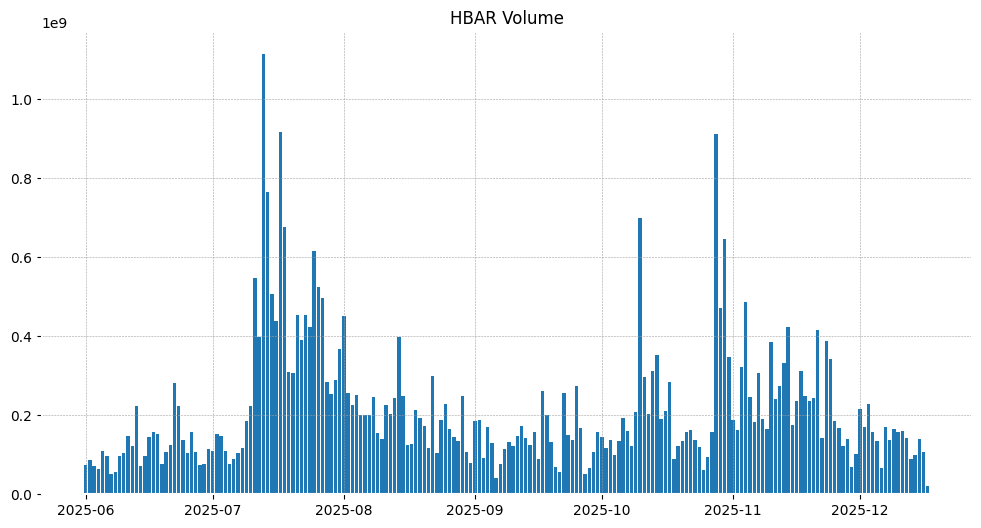

In [82]:
df_plot = df_daily[-200:].copy()
df_plot = df_plot.set_index("time_stamp")

# ---- Candlestick chart ----
mpf.plot(
    df_plot,
    type="candle",
    style="charles",
    volume=False,
    title="HBAR Candlestick",
    figsize = (20,6)
)

# ---- Volume chart (separate) ----
plt.figure(figsize=(12,6))
plt.bar(df_plot.index, df_plot["volume"], width=0.8)
plt.title("HBAR Volume")
plt.show()

In [83]:
df_daily['pct_change']  = compute_percentage_changes(df_daily['close'])
df_daily['log_return']= compute_log_returns(df_daily['close'])
df_daily = df_daily.dropna()

In [84]:
df_daily['pct_change'].mul(100).describe()

count    730.000000
mean       0.229514
std        6.445662
min      -22.824811
25%       -2.923356
50%       -0.275590
75%        2.254944
max       72.898230
Name: pct_change, dtype: float64

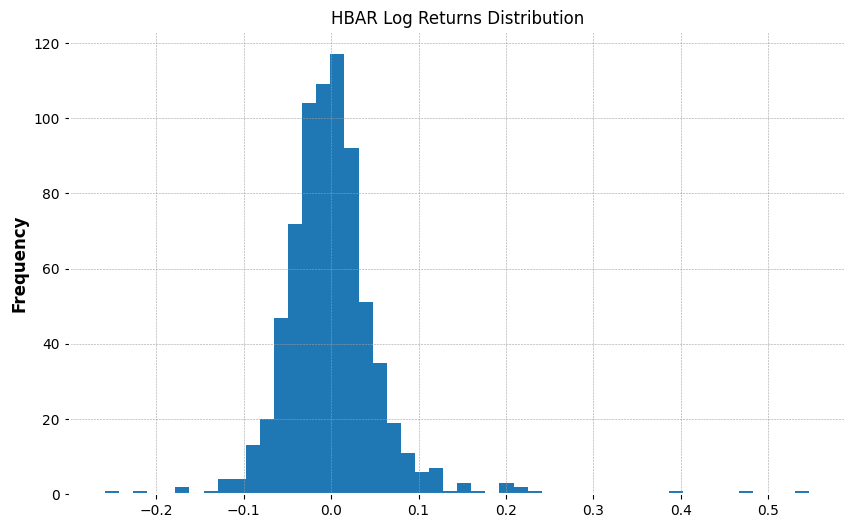

In [85]:
df_daily.log_return.plot(kind='hist', bins=50, figsize=(10,6), title="HBAR Log Returns Distribution")
plt.show()

In [89]:
# Find all candles where the open price is greater than the previous close price
df_daily[(df_daily.open - df_daily.close.shift()) > 0.001]

,time_stamp,open,high,low,close,volume,pct_change,log_return


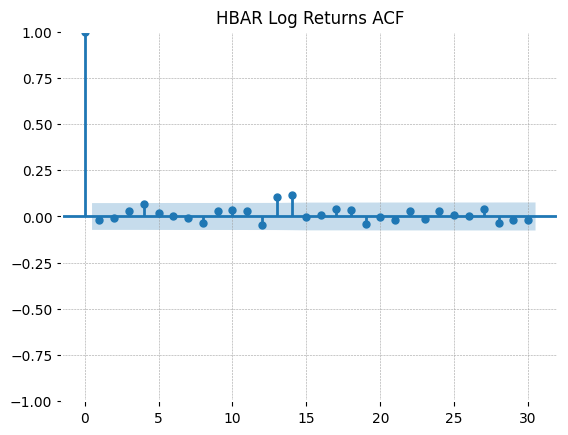

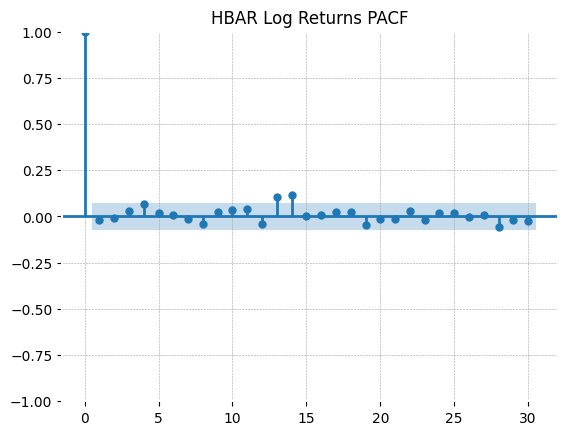

In [91]:
plot_acf(df_daily['log_return'], lags=30, title="HBAR Log Returns ACF");
plot_pacf(df_daily['log_return'], lags=30, title="HBAR Log Returns PACF");

In [92]:
# Perform ADF test: time series stationarity test
adf_test(df_daily['log_return'])
print("\n")
# Perform KPSS test: time series stationarity test
kpss_test(df_daily['log_return'])

Results of Dickey-Fuller Test:
Test Statistic                  -5.450888
p-value                          0.000003
#Lags Used                      13.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64


Results of KPSS Test:
Test Statistic           0.135425
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


D:\My Files\Projects\Python\trade-tools\src\crypto\utils.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
